# Notebook Dedicated to Study the Response of the Trained Classifier when Passing Real Data sets to perform Predictions

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn
import pandas as pd

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
#from tensorflow.keras.models import Model, Sequential
#from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
#from keras.losses import BinaryCrossentropy
#from sklearn.metrics import roc_curve
#from sklearn.metrics import auc
#from sklearn.utils import shuffle

In [100]:
import colorsys
# Función para generar variantes más claras y más oscuras de un color
def generate_color_variants(base_color, num_variants, factor = 0.3):
    # Convertir el color base a valores de HSV
    r, g, b = base_color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    # Generar variantes
    variants = []
    for i in range(1, num_variants + 1):
        # Hacer el color más claro
        lighter = colorsys.hls_to_rgb(h, min(1, l * (1 + factor * i)), s)
        # Hacer el color más oscuro
        darker = colorsys.hls_to_rgb(h, max(0, l * (1 - factor * i)), s)
        variants.append(lighter)
        variants.append(darker)
        
    return variants

# Color base (rojo)
base_red = (1, 0, 0) # RGB para rojo puro
# Color base (azuk)
base_blue = (0, 0, 1) # RGB para azul puro
num_variants = 5

red_variants = generate_color_variants(base_red, num_variants)
blue_variants = generate_color_variants(base_blue, num_variants)

# Load and Extract the Data

In [3]:
#Choose the real dataset based on the cuts on energy ans position
en_inf_cut = 3.5
en_sup_cut = 12
posr_cut = 5000

#Load Data
real_data_dir = f'C:/Users/joanc/jupyter notebooks/solar neutrino analysis/real data analysis/real_dataset_ML/real_dataset_E_{en_inf_cut}_{en_sup_cut}_MeV_R_{posr_cut}_mm.csv'

df_real_data = pd.read_csv(real_data_dir)
df_real_data.head()

,Unnamed: 0,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_92,pixel_93,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm)
0,0,0.0,0.00,0.0,0.2,0.000000,0.10,0.058824,0.131579,0.148148,...,0.000000,0.200000,0.111111,0.000000,0.000000,0.105263,0.037037,0.133333,4.044874,2425.253906
1,1,0.0,0.25,0.0,0.0,0.117647,0.00,0.000000,0.076923,0.107143,...,0.125000,0.000000,0.117647,0.153846,0.160000,0.076923,0.178571,0.068966,3.546911,3926.669922
2,2,0.0,0.00,0.0,0.2,0.083333,0.25,0.000000,0.000000,0.000000,...,0.142857,0.200000,0.166667,0.250000,0.166667,0.090909,0.000000,0.034483,3.584208,1686.395874
3,3,0.0,0.00,0.0,0.0,0.076923,0.00,0.000000,0.080000,0.000000,...,0.142857,0.111111,0.230769,0.238095,0.058824,0.240000,0.178571,0.193548,4.000314,3871.861816
4,4,0.0,0.00,0.0,0.0,0.000000,0.05,0.000000,0.000000,0.023256,...,0.090909,0.125000,0.277778,0.150000,0.178571,0.111111,0.232558,0.189189,4.135279,3998.809082


In [18]:
#Separate observables
pixel_pattern = r'^pixel_\d+$'

df_pixel = df_real_data.filter(regex=pixel_pattern)
df_energy = df_real_data[['energy (MeV)']]
df_radius = df_real_data[['radius (mm)']]

# Transform the Data with Standard Scaler and Normalize the Radius of event by the Volume

In [33]:
#First, normalize the Radius
vol = posr_cut**3
df_norm_radius = (df_radius**3/vol)

#Proceed with Std. Scaler
scaler_pixels = StandardScaler()
scaler_energy = StandardScaler()
scaler_radius = StandardScaler()

pixel_transf = scaler_pixels.fit_transform(df_pixel)
energy_transf = scaler_energy.fit_transform(df_energy).T[0]
norm_radius_transf = scaler_pixels.fit_transform(df_norm_radius).T[0]

In [39]:
pixel_transf.shape

(136, 100)

# Load the Classifier Model

In [36]:
model_dir = 'C:/Users/joanc/jupyter notebooks/solar neutrino analysis/Machine Learning/models/10x10/optimized models/std_transf_and_Std_Norm_Vol_models/Observed Nu Energy for train/'
model_name = 'MLM4_5500_(2.5_12)_(-5_7)_aucOP_test_split.h5'

model = tf.keras.models.load_model(model_dir + model_name)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_0 (Dense)               │ (None, 72)                │           7,272 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_1 (Dense)               │ (None, 56)                │           4,088 │ im_ly_0[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_2 (Dense)               │ (None, 53)                │           3,021 │ im_ly_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_3 (Dense)               │ (None, 52)                │           2,808 │ im_ly_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_4 (Dense)               │ (None, 51)                │           2,703 │ im_ly_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_5 (Dense)               │ (None, 50)                │           2,600 │ im_ly_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_6 (Dense)               │ (None, 50)                │           2,550 │ im_ly_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_7 (Dense)               │ (None, 50)                │           2,550 │ im_ly_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_8 (Dense)               │ (None, 50)                │           2,550 │ im_ly_7[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ energy_input (InputLayer)     │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ radius_input (InputLayer)     │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 52)                │               0 │ im_ly_8[0][0],             │
│                               │                           │                 │ energy_input[0][0],        │
│                               │                           │                 │ radius_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_ly_0 (Dense)              │ (None, 80)                │           4,240 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_layer1 (Dense)            │ (None, 30)                │           2,430 │ bdo_ly_0[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_layer2 (Dense)            │ (None, 30)                │             930 │ bdo_layer1[0][0]           │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 39,916 (155.93 KB)

 Trainable params: 39,914 (155.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# Model Predictions

In [50]:
predictions = model.predict([pixel_transf, energy_transf, norm_radius_transf])

sig_prediction = predictions[:,0]
bkg_prediction = predictions[:,1]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [77]:
sig_prediction

array([2.10357277e-04, 1.00000000e+00, 9.49844480e-01, 3.82169958e-07,
       2.03234123e-07, 4.03563492e-03, 3.24893954e-05, 8.64860177e-01,
       8.63309264e-01, 3.05356088e-11, 9.99999940e-01, 1.19137636e-03,
       9.55290869e-02, 3.04644141e-14, 3.74475829e-02, 5.09103480e-12,
       4.73536869e-11, 9.99999940e-01, 9.23780560e-01, 1.00000000e+00,
       9.10164715e-07, 2.58173793e-09, 9.77770030e-01, 1.00000000e+00,
       1.35699004e-12, 1.82988569e-01, 9.99997497e-01, 9.96332526e-01,
       9.99884188e-01, 1.81763667e-07, 1.00000000e+00, 7.86324872e-09,
       1.00000000e+00, 3.42689484e-04, 1.33690328e-05, 3.84382446e-08,
       3.17709579e-04, 1.37335714e-03, 1.81265009e-18, 6.84090436e-01,
       1.27451167e-05, 2.61898240e-04, 1.38265355e-09, 1.00000000e+00,
       1.00000000e+00, 3.44412121e-09, 1.00000000e+00, 9.99984860e-01,
       1.00000000e+00, 2.30320066e-01, 6.92269742e-01, 1.19441146e-09,
       1.62543001e-05, 3.82110965e-03, 1.00000000e+00, 1.19062314e-07,
      

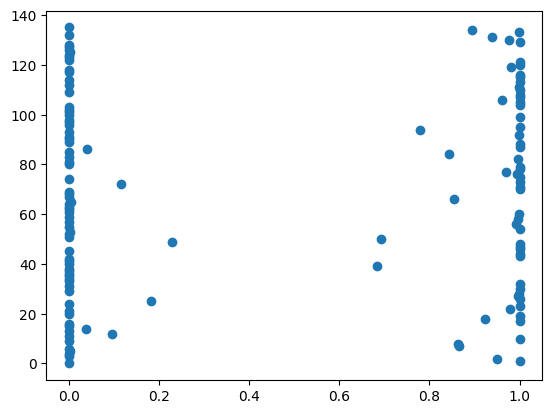

In [76]:
plt.scatter(sig_prediction, range(len(sig_prediction)))

## Apply thesholds to select predicted events and Observe their Energy

In [63]:
thr_list = [0.95, 0.8, 0.70] #List with the threshold values to filter events

#lists to be filled with lists (one for each thr value) with the energy values for events that pass the thr values as suspected backgrounds and suspected signals
energy_sig_thr = [] 
energy_bkg_thr = []

for thr_value in thr_list:

    #Take the index where the thr value is satisfied
    sig_index = np.where(sig_prediction > thr_value)[0]
    bkg_index = np.where(bkg_prediction > thr_value)[0]

    #Extract the energy of events that survives the thr selection
    sig_energy_survive = np.array(df_energy).T[0][sig_index]
    bkg_energy_survive = np.array(df_energy).T[0][bkg_index]

    #Save the filtered Values
    energy_sig_thr.append(sig_energy_survive)
    energy_bkg_thr.append(bkg_energy_survive)

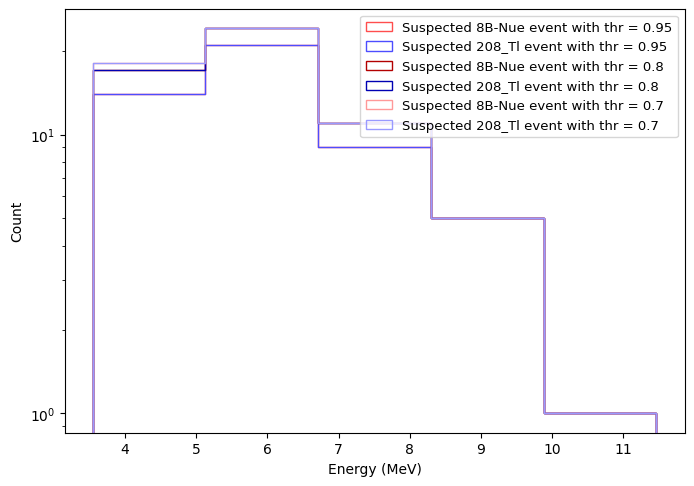

In [106]:
bins = 5

plt.figure(figsize = (8, 5.5))
for i_dx, thr_value in enumerate(thr_list):

    sn.histplot(energy_sig_thr[i_dx], alpha = 0, element = 'step', bins = bins, 
                color = red_variants[i_dx], label = f'Suspected 8B-Nue event with thr = {thr_value}')
    sn.histplot(energy_sig_thr[i_dx], alpha = 0, element = 'step', bins = bins, 
                color = blue_variants[i_dx], label = f'Suspected 208_Tl event with thr = {thr_value}')

plt.legend(loc='best', fontsize = 9.5)
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.show()